In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np

from wufam.data.prepare_data import read_kf_data
from wufam.config.trading_config import TradingConfig
from wufam.dataset import Dataset
from wufam.strategies.optimization_data import TrainingData, PredictionData
from wufam.metrics.metrics import calc_sharpe_from_weights

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_6_M
FACTORS_DATASET = Dataset.FACTORS_M
WEIGHTING = "value_weighted"
FACTOR_ANNUALIZE = 12

## 1.1

In [3]:
portfolios_total_r, portfolios_xs_r, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / DATASET,
    factors_filename=PATH / FACTORS_DATASET,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

In [4]:
assert (
    portfolios_total_r.shape[0]
    == portfolios_xs_r.shape[0]
    == factors_df.shape[0]
    == rf.shape[0]
)

## 1.2

In [5]:
from wufam.strategies.heuristics.equally_weighted import EWStrategy
from wufam.strategies.optimized.mean_var import MeanVariance
from wufam.strategies.optimized.min_var import MinVariance

trading_config = TradingConfig(total_exposure=1)

ew_strategy = EWStrategy()

In [6]:
from wufam.estimation.mean.sample_mu_estimator import SampleMuEstimator
from wufam.estimation.covariance.sample_cov_estimator import SampleCovEstimator

mv_strategy = MeanVariance(
    mu_estimator=SampleMuEstimator(),
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [7]:
from wufam.estimation.covariance.shrinkage.lw_cv_cov_estimator import (
    LedoitWolfCVCovEstimator,
)

# trading_config_min_var = TradingConfig(total_exposure=1, min_exposure=0.0)

min_var_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(alphas=np.linspace(0.0, 1.0, 100)),
    # cov_estimator=LedoitWolfCVCovEstimator(),
    # trading_config=trading_config_min_var,
    trading_config=trading_config,
    window_size=None,
)

In [8]:
training_data = TrainingData(
    simple_excess_returns=portfolios_xs_r,
)

ew_strategy.fit(training_data)
mv_strategy.fit(training_data)
min_var_strategy.fit(training_data)

In [9]:
prediction_data = PredictionData()

ew_weights = ew_strategy(prediction_data)
mv_weights = mv_strategy(prediction_data)
min_var_weights = min_var_strategy(prediction_data)

In [10]:
ew_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [11]:
mv_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,-2.367576,2.543004,0.618445,1.585893,-1.099746,-0.28002


In [12]:
min_var_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,-0.67868,0.673626,-0.004209,0.657938,0.526838,-0.175513


In [13]:
min_var_strategy.cov_estimator.best_alpha

np.float64(0.010101010101010102)

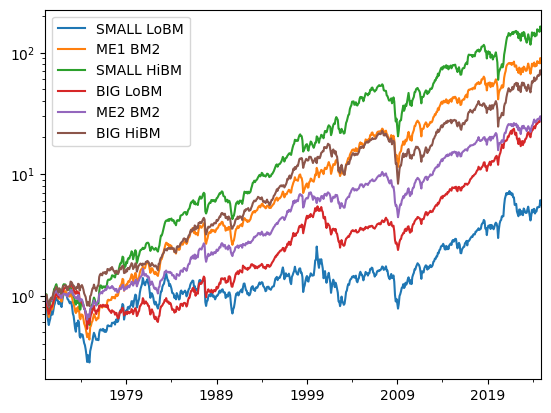

In [14]:
portfolios_xs_r.add(1).cumprod().plot(logy=True);

In [15]:
calc_sharpe_from_weights(
    weights=ew_weights,
    excess_ret=portfolios_xs_r,
    rf_rate=rf,
    factor_annualize=FACTOR_ANNUALIZE,
)

0.45848777672322566

In [16]:
calc_sharpe_from_weights(
    weights=mv_weights,
    excess_ret=portfolios_xs_r,
    rf_rate=rf,
    factor_annualize=FACTOR_ANNUALIZE,
)

0.579174415473971

In [17]:
calc_sharpe_from_weights(
    weights=min_var_weights,
    excess_ret=portfolios_xs_r,
    rf_rate=rf,
    factor_annualize=FACTOR_ANNUALIZE,
)

0.5970620987892907

## 1.3.

In [18]:
split_date = portfolios_xs_r.index[len(portfolios_xs_r) // 2]

training_data = TrainingData(
    simple_excess_returns=portfolios_xs_r.loc[:split_date],
)

ew_strategy.fit(training_data)
mv_strategy.fit(training_data)
min_var_strategy.fit(training_data)

ew_weights = ew_strategy(prediction_data)
mv_weights = mv_strategy(prediction_data)
min_var_weights = min_var_strategy(prediction_data)

In [19]:
min_var_strategy.cov_estimator.best_alpha

np.float64(0.07070707070707072)

In-sample.

In [20]:
calc_sharpe_from_weights(
    weights=ew_weights,
    excess_ret=portfolios_xs_r.loc[:split_date],
    rf_rate=rf,
    factor_annualize=FACTOR_ANNUALIZE,
)

0.36428230781888277

In [21]:
calc_sharpe_from_weights(
    weights=mv_weights,
    excess_ret=portfolios_xs_r.loc[:split_date],
    rf_rate=rf,
    factor_annualize=FACTOR_ANNUALIZE,
)

0.6677153781492747

In [22]:
calc_sharpe_from_weights(
    weights=min_var_weights,
    excess_ret=portfolios_xs_r.loc[:split_date],
    rf_rate=rf,
    factor_annualize=FACTOR_ANNUALIZE,
)

0.5557148617374265

Out-of-sample.

In [23]:
calc_sharpe_from_weights(
    weights=ew_weights,
    excess_ret=portfolios_xs_r.loc[split_date:],
    rf_rate=rf,
    factor_annualize=FACTOR_ANNUALIZE,
)

0.05179634255272154

In [24]:
calc_sharpe_from_weights(
    weights=mv_weights,
    excess_ret=portfolios_xs_r.loc[split_date:],
    rf_rate=rf,
    factor_annualize=FACTOR_ANNUALIZE,
)

0.21203001767891663

In [25]:
calc_sharpe_from_weights(
    weights=min_var_weights,
    excess_ret=portfolios_xs_r.loc[split_date:],
    rf_rate=rf,
    factor_annualize=FACTOR_ANNUALIZE,
)

0.11527221945753846

Factor => Doesn't improve, as should've shorted

In [26]:
long_columns = [col for col in portfolios_xs_r.columns if "HiBM" in col]
short_columns = [col for col in portfolios_xs_r.columns if "LoBM" in col]

repl = portfolios_total_r[long_columns].mean(axis=1) - portfolios_total_r[
    short_columns
].mean(axis=1)

In [27]:
np.abs(factors_df["HML"].to_numpy() - repl.round(4).to_numpy()).mean()

np.float64(4.5454545454650823e-07)

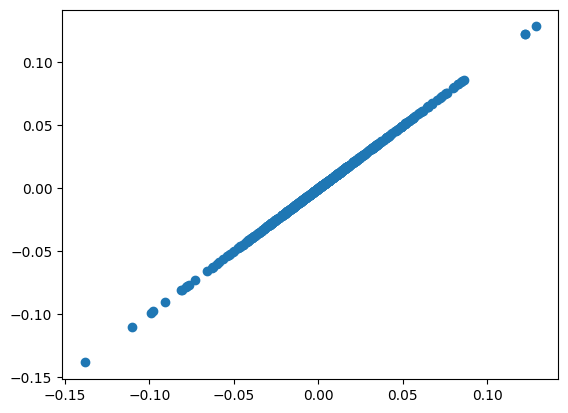

In [28]:
import matplotlib.pyplot as plt

plt.scatter(factors_df["HML"].to_numpy(), repl.round(4).to_numpy());

In [29]:
np.corrcoef(factors_df["HML"].to_numpy(), repl.round(4).to_numpy())

array([[1.        , 0.99999998],
       [0.99999998, 1.        ]])

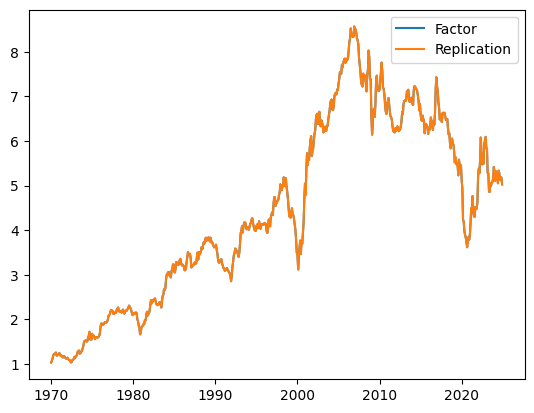

In [30]:
plt.plot(factors_df["HML"].add(1).cumprod(), label="Factor")
plt.plot(repl.round(4).add(1).cumprod(), label="Replication")
plt.legend()
plt.show()